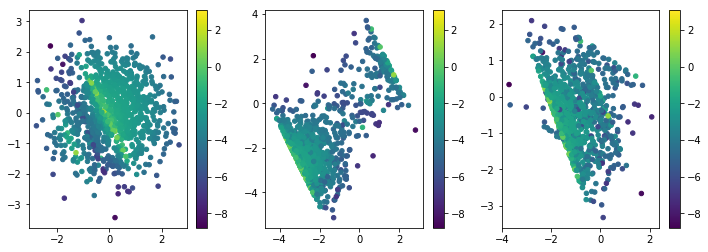

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from planar_numpy import planar_flow, to_simplex
from scipy.stats import multivariate_normal, dirichlet
from dirichlet import simplex

D = 2;
n = 1000;
n_plot = 1000;

# planar flow layer 1 params
u1 = -np.expand_dims(np.array([-3.173, -2.739]), 1);
w1 = -np.expand_dims(np.array([1.898, 1.038]), 1);
b1 = -2.004; 

# planar flow layer 2 params
u2 = -np.expand_dims(np.array([-1.407, -1.804]), 1);
w2 = -np.expand_dims(np.array([1.115, 2.369]), 1);
b2 = -.848; 

z0 = np.random.normal(0, 1, (D, n));
dist = multivariate_normal(np.zeros((2,)), np.eye(2));
base_logq = dist.logpdf(z0.T);
size = 20*np.ones((n_plot,));

z1, log_det_jac1 = planar_flow(z0, u1, w1, b1);
z2, log_det_jac2 = planar_flow(z1, u2, w2, b2);

logq = base_logq - log_det_jac1 - log_det_jac2;

fig = plt.figure(figsize=(12,4));
fig.add_subplot(1,3,1);
plt.scatter(z0[0,:n_plot], z0[1,:n_plot], size, logq[:n_plot]);
plt.colorbar();
fig.add_subplot(1,3,2);
plt.scatter(z1[0,:n_plot], z1[1,:n_plot], size, logq[:n_plot]);
plt.colorbar();
fig.add_subplot(1,3,3);
plt.scatter(z2[0,:n_plot], z2[1,:n_plot], size, logq[:n_plot]);
plt.colorbar();



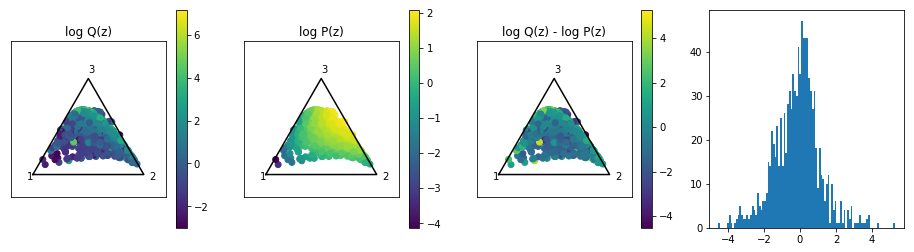

-0.14429122845581402


In [2]:
y, log_det_jac_simp1, log_det_jac_simp2 = to_simplex(z2);

logq = base_logq - log_det_jac1 - log_det_jac2 - log_det_jac_simp1;

alpha = np.array([1,2,3]);
dist_targ = dirichlet(alpha);
logp = dist_targ.logpdf(y);

KL_ptwise = logq-logp;

fig = plt.figure(figsize=(16,4));
fig.add_subplot(1,4,1);
simplex.scatter(y[:,:n_plot].T, connect=False, c=logq[:n_plot]);
plt.title('log Q(z)')
plt.colorbar();
fig.add_subplot(1,4,2);
simplex.scatter(y[:,:n_plot].T, connect=False, c=logp[:n_plot]);
plt.title('log P(z)')
plt.colorbar();
fig.add_subplot(1,4,3);
simplex.scatter(y[:,:n_plot].T, connect=False, c=KL_ptwise[:n_plot]);
plt.title('log Q(z) - log P(z)')
plt.colorbar();
fig.add_subplot(1,4,4);
plt.hist(KL_ptwise, 100);
plt.show();

KL = np.mean(logq - logp);
print(KL);

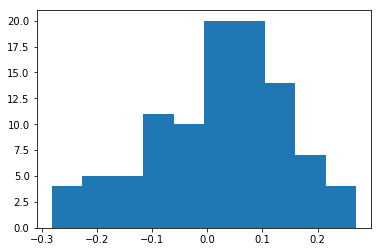

In [3]:
nsamps = 100;
n_i = n // 10;
KLs = np.zeros((nsamps,));
inds = np.arange(nsamps);
for i in range(nsamps):
    inds_i = np.random.choice(inds, n_i);
    KLs[i] = np.mean(logq[inds_i] - logp[inds_i]);
plt.figure();
plt.hist(KLs);
plt.show();

In [22]:
import lasagne
import theano
import theano.tensor as T
from lasagne.layers import InputLayer
import sys
sys.path.append('utils/');
from normalizing_flow_utils import PlanarFlow
from layers_utils import ExpLayer, SimplexBijectionLayer
from numpy.random import RandomState

np.random.seed(222)
lasagne.random.set_rng(RandomState(222))
z0_th = T.matrix("z") #input

l_hid = InputLayer(shape=(None, D), input_var=z0_th)

out0 = lasagne.layers.get_output(l_hid);
l_hid = PlanarFlow(l_hid, w=lasagne.init.Constant(w1.T), u=lasagne.init.Constant(u1.T), b=lasagne.init.Constant(b1));
logdet = l_hid.det(out0)
us_fn = theano.function(inputs=[], outputs=[l_hid.u0, l_hid.u]);
print(us_fn());

out1 = lasagne.layers.get_output(l_hid)
l_hid = PlanarFlow(l_hid, w=lasagne.init.Constant(w2.T), u=lasagne.init.Constant(u2.T), b=lasagne.init.Constant(b2));
logdet += l_hid.det(out1)
        
out2 = lasagne.layers.get_output(l_hid)
l_hid = SimplexBijectionLayer(l_hid)
out_simplex = lasagne.layers.get_output(l_hid)
logdet += l_hid.det(out2)

y_fn = theano.function(inputs=[z0_th], outputs=out_simplex);
sum_log_det_fn = theano.function(inputs=[z0_th], outputs=logdet);

[array([[3.173, 2.739]]), array([[-0.01703213,  0.99439866]])]


[[-4158.365156  ]
 [-4157.32157595]
 [-4156.57813741]
 [-4155.97575617]
 [-4155.9768683 ]
 [-4156.46133757]
 [-4156.5873665 ]
 [-4156.07749121]
 [-4157.16673855]
 [-4156.31814852]
 [-4163.62363666]
 [-4156.31001696]
 [-4161.34403215]
 [-4156.54143757]
 [-4156.69320379]
 [-4156.10943548]
 [-4156.02059859]
 [-4156.03302193]
 [-4156.06931002]
 [-4159.93678402]
 [-4158.95697908]
 [-4155.98454195]
 [-4156.49730802]
 [-4156.50583476]
 [-4158.03166359]
 [-4157.26351506]
 [-4155.99465431]
 [-4157.2125863 ]
 [-4157.1031143 ]
 [-4158.52976882]
 [-4160.11807603]
 [-4156.02774606]
 [-4156.01556623]
 [-4156.23088902]
 [-4156.60727734]
 [-4156.16977663]
 [-4157.61294353]
 [-4156.59259872]
 [-4156.07922603]
 [-4157.59923807]
 [-4157.9826815 ]
 [-4156.00961709]
 [-4155.97839043]
 [-4156.11449467]
 [-4156.16342861]
 [-4156.01661866]
 [-4156.28024265]
 [-4157.5237659 ]
 [-4156.08927889]
 [-4160.66565955]
 [-4156.08558556]
 [-4156.02614699]
 [-4159.83440199]
 [-4157.3356471 ]
 [-4156.0355017 ]
 [-4156.06

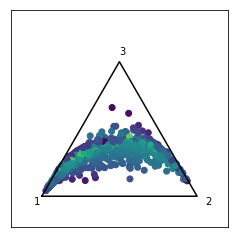

In [18]:
y_lasagne = y_fn(z0.T);
sum_log_dets = sum_log_det_fn(z0.T);
print(sum_log_dets)
simplex.scatter(y_lasagne[:n_plot,:], connect=False, c=logq[:n_plot]);

In [15]:
print(w1)

[[-1.898]
 [-1.038]]
